In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import shap
import sys
import os

# Scikit-learn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# To import from the `src/` directory, we add it to the Python path.
# This is a robust way to access our pipeline's configuration,
# honoring the project's architecture.
try:
    # Get the project root assuming the notebook is in `notebooks/`
    project_root = os.path.dirname(os.getcwd())
    src_dir = os.path.join(project_root, "src")
    sys.path.append(src_dir)
    from modeling_pipeline import Config

    print("Successfully imported Config from src/modeling_pipeline.py")
except (ImportError, ModuleNotFoundError):
    print(
        "Could not import Config. Please ensure the notebook is in the correct directory."
    )
    # Define a fallback or exit if the import fails
    sys.exit()

c:\Users\johnl\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Successfully imported Config from src/modeling_pipeline.py


In [3]:
print("--- Preparing the Champion Model: LogisticRegression on Baseline ---")

# Load the baseline dataset using our shared configuration
dataset_path = Config.DATASETS["baseline"]
df = pd.read_csv(dataset_path)

# Prepare data using the central configuration
df[Config.TARGET_VARIABLE] = df[Config.TARGET_VARIABLE].map(
    {"positive": 1, "negative": 0}
)
X = df.drop(columns=[Config.TARGET_VARIABLE])
y = df[Config.TARGET_VARIABLE]

# Create a final, reproducible train/test split for this notebook
# We use a fixed random_state for consistency and stratify due to the data skew
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=Config.TEST_SIZE,
    random_state=42,  # A standard for reproducible splits
    stratify=y,
)

# Dynamically identify feature types, just as our pipeline does
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

# Create the exact same preprocessor to ensure consistency
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="passthrough",
)

# Initialize and train the final Logistic Regression model within a scikit-learn Pipeline
# This pipeline handles preprocessing and modeling in one clean, architectural step
champion_model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=42, max_iter=1000)),
    ]
)

champion_model_pipeline.fit(X_train, y_train)

print("\nChampion model trained successfully within a reproducible pipeline.")

--- Preparing the Champion Model: LogisticRegression on Baseline ---

Champion model trained successfully within a reproducible pipeline.


In [4]:
print("--- Generating SHAP values ---")

# For SHAP, we need the trained classifier and the transformed data
model = champion_model_pipeline.named_steps["classifier"]
preprocessor_fitted = champion_model_pipeline.named_steps["preprocessor"]

# Transform the data so the explainer sees exactly what the model saw
X_train_transformed = preprocessor_fitted.transform(X_train)
X_test_transformed = preprocessor_fitted.transform(X_test)

# Get the feature names *after* one-hot encoding for clear plot labels
# This is a critical step for human-centric interpretability
try:
    ohe_feature_names = (
        preprocessor_fitted.named_transformers_["cat"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
except AttributeError:  # Fallback for older scikit-learn versions
    ohe_feature_names = (
        preprocessor_fitted.named_transformers_["cat"]
        .get_feature_names(categorical_features)
        .tolist()
    )

feature_names = numerical_features + ohe_feature_names

# For linear models, LinearExplainer is the most efficient and accurate explainer
explainer = shap.LinearExplainer(model, X_train_transformed)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_transformed)

print("SHAP values calculated successfully.")

--- Generating SHAP values ---
SHAP values calculated successfully.



SHAP Summary Plot (Global Feature Importance):


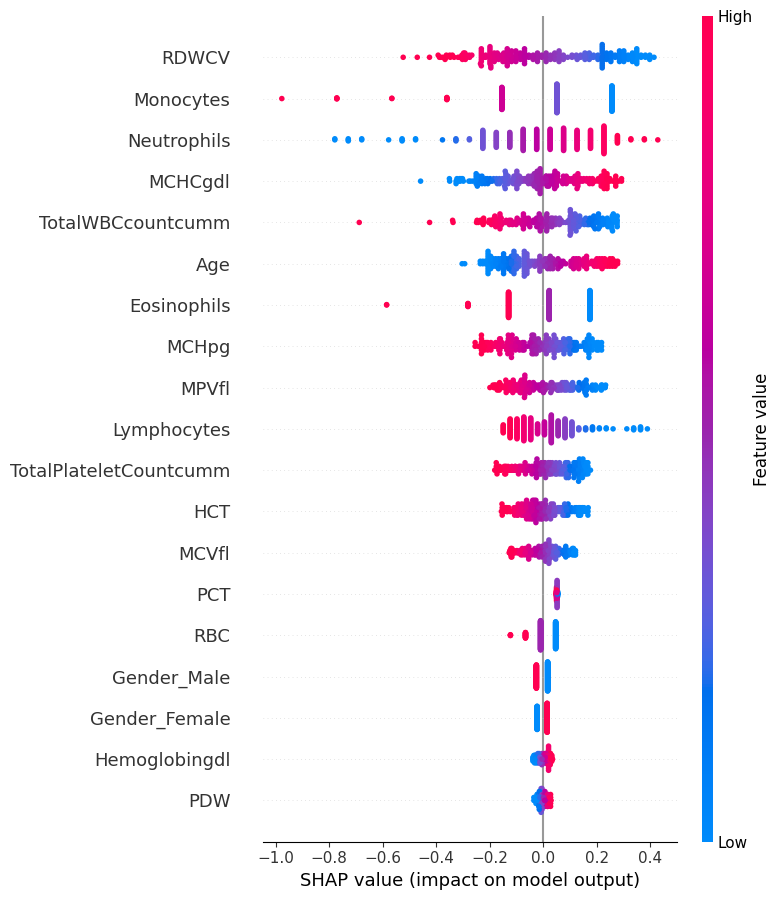

In [5]:
print("\nSHAP Summary Plot (Global Feature Importance):")

# To make the plot interpretable, we pass the transformed data
# and the correct feature names we just generated.
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

SHAP Explanation object has been restructured with feature names.

Generating SHAP Waterfall Plot for generation and visualization...

--- Generating synthesized plot (Waterfall) ---
Final artifact recorded at: 'shap_waterfall_plot_instance_0_final.png'


<Figure size 640x480 with 0 Axes>

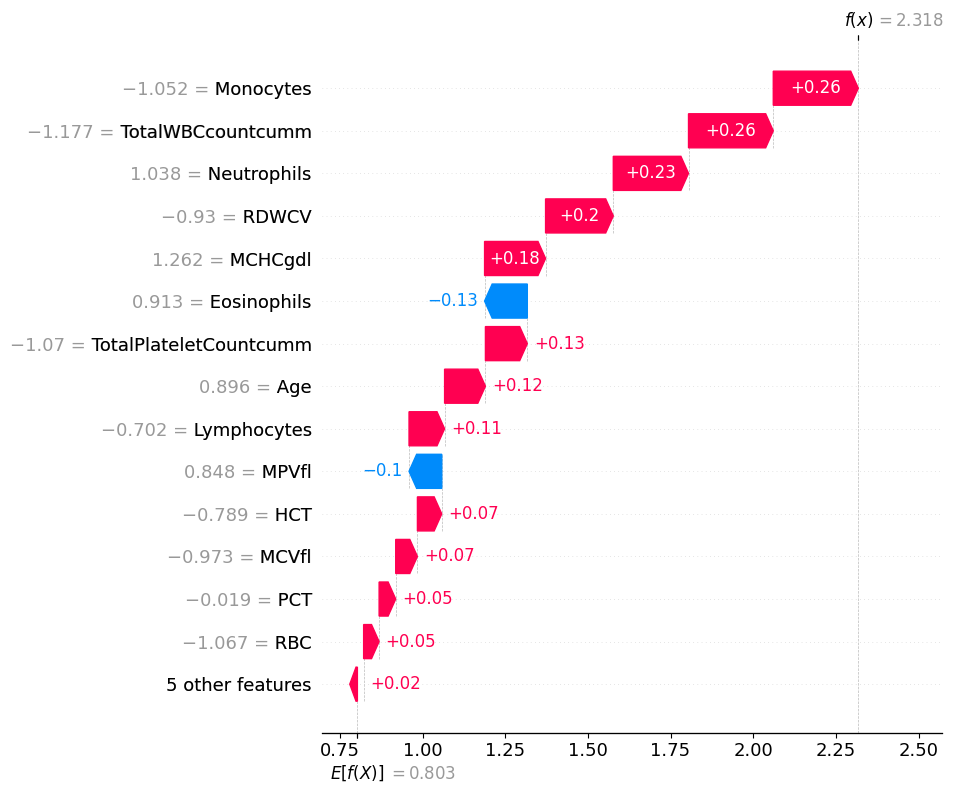

In [12]:
import matplotlib.pyplot as plt

X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

shap_explanation_object_named = shap.Explanation(
    values=shap_values.values,
    base_values=shap_values.base_values,
    data=X_test_transformed_df,  # Pass the DataFrame with names
    feature_names=feature_names,
)
print("SHAP Explanation object has been restructured with feature names.")

print("\nGenerating SHAP Waterfall Plot for generation and visualization...")
instance_index = 0
threshold = 0.05

print("\n--- Generating synthesized plot (Waterfall) ---")

# Step 1: Define the canvas (optional, but good for sizing)
plt.figure(figsize=(10, 8))  # Adjusted for a vertical layout

# Step 2: Generate the waterfall plot
# This plot is ideal for showing single-instance explanations without text overlap.
shap.waterfall_plot(
    shap_explanation_object_named[instance_index],
    max_display=15,  # Shows the top 15 most impactful features
    show=False,
)

# Step 3: Record
output_filename = f"shap_waterfall_plot_instance_{instance_index}_final.png"
plt.savefig(output_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Final artifact recorded at: '{output_filename}'")

# Step 4: Visualize and Reset
plt.show()
plt.clf()